# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import random
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble      import RandomForestRegressor


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow 
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

In [3]:
import random, os

seed=42

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## Data handling parameters

In [4]:
# Parameters
#
filename   = 'metadata/6-kanal-2.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [7]:
Lag        =   12
Horizon    =   6
#
epochs     =  200
batch_size =   16

# Data handling

## Import data


In [8]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.08 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-01-29 00:00:06,25.4,17.0,1.2,1.7,214.0,298.0
1,2022-01-29 00:00:21,25.4,17.0,1.2,2.0,213.0,299.0
2,2022-01-29 00:00:41,25.3,17.0,1.2,1.4,214.0,299.0


## Preprocess data

### Set index

In [9]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df['PM2.5'] )
df.head(3)

,PM2.5
Date,
2022-01-29 00:00:00,1.227778
2022-01-29 00:05:00,1.833333
2022-01-29 00:10:00,1.626316


In [10]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [11]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

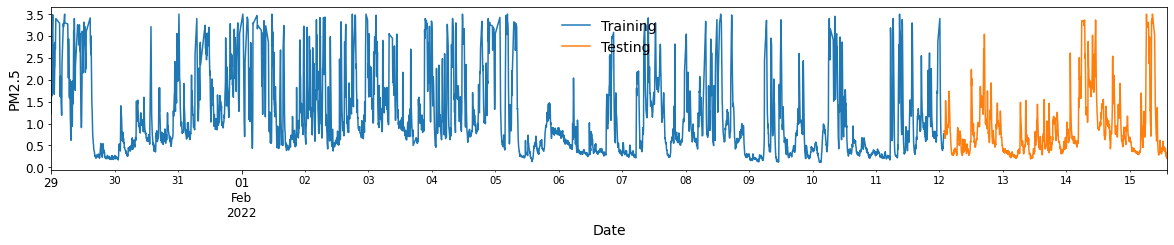

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train.plot(ax=ax, color='tab:blue' )
df_test.plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [13]:
df_test = pd.concat([df_train.iloc[-Lag-Horizon:], df_test])

## Preprocessing

## Data Transformation

In [14]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
        
    df_train = np.log( df_train )
    df_test  = np.log( df_test  )   
    
else:
    print('[INFO] No data transformation applied.')    

[INFO] Data transformation applied


In [15]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )    

[INFO] Scaling: Standard


## Create Training/Testing data

In [16]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    
    dataX, dataY = [], []
    for idx in tqdm( range(0, df.shape[0] + 1  - Lag-Horizon - Horizon, overlap) ):
        
        data = df[ targetSeries ][idx:idx+Lag+Horizon].copy()
        
        Instances = []
        for i in range(1, Horizon+1):
            Instance  = data.diff(i)[-Lag:].to_list()
            Instance += [ df[ targetSeries ][idx+Lag+Horizon-1] ]
                        
            Instances += [ np.asarray(Instance) ]
            
        dataX.append( Instances )
        
       
    
    
        # Target Instance
        Instance = (df[ targetSeries ].to_numpy()[idx + Lag+Horizon : idx + Lag+Horizon + Horizon] - df[ targetSeries ][idx+Lag+Horizon-1] )

        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY) )

In [17]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Lag // 2)
                               

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Horizon)


print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 169/169 [00:00<00:00, 911.03it/s]

Training instances:      672
Testing instances:       169


In [18]:
trainX = np.swapaxes(trainX, 2, 1)
testX  = np.swapaxes(testX, 2, 1)

# Forecasting model: NBeats

## Training process

In [19]:
from utils.NBeats_Keras import NBeatsNet

model = NBeatsNet(input_dim          = trainX.shape[2],
                  stack_types        = (NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  forecast_length    = Horizon,
                  backcast_length    = Lag,
                  hidden_layer_units = 64)

In [20]:
# Define metrics
#
metrics = [
            MeanAbsolutePercentageError(name = "MAPE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss      = 'mse', 
              optimizer = Adam(learning_rate = 1.e-4), 
              metrics   = metrics)


# Checkpoint
#
checkpoint = ModelCheckpoint("models/NBeats_d-diff.hdf5", 
                              monitor        = 'val_RMSE', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_RMSE', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_RMSE', 
                                   factor      = 0.5,
                                   patience    = 5)

In [21]:
# Start clock
#
start = time.time()


score = model.fit(trainX[:,:-1,], trainY, 
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],                  
                  verbose         = 1, 
                  validation_data = (testX[:,:-1,:], testY))


# Terminate clock
#
stop = time.time()
print('[INFO] Time %.2f' % (stop - start))



Train on 672 samples, validate on 169 samples
Epoch 1/200
672/672 [==============================] - 16s 25ms/sample - loss: 0.2791 - MAPE: 256576.4688 - RMSE: 0.5283 - val_loss: 0.2039 - val_MAPE: 304013.2812 - val_RMSE: 0.4516
Epoch 2/200
672/672 [==============================] - 1s 2ms/sample - loss: 0.2703 - MAPE: 378269.5000 - RMSE: 0.5199 - val_loss: 0.2005 - val_MAPE: 369549.8125 - val_RMSE: 0.4478
Epoch 3/200
672/672 [==============================] - 1s 2ms/sample - loss: 0.2670 - MAPE: 354223.6250 - RMSE: 0.5167 - val_loss: 0.1998 - val_MAPE: 471578.1250 - val_RMSE: 0.4470
Epoch 4/200
672/672 [==============================] - 1s 2ms/sample - loss: 0.2655 - MAPE: 358867.0625 - RMSE: 0.5153 - val_loss: 0.1993 - val_MAPE: 530263.1250 - val_RMSE: 0.4465
Epoch 5/200
672/672 [==============================] - 1s 2ms/sample - loss: 0.2642 - MAPE: 414176.1875 - RMSE: 0.5140 - val_loss: 0.1989 - val_MAPE: 612715.0000 - val_RMSE: 0.4460
Epoch 6/200
672/672 [==========================

## Evaluation

In [22]:
# Load the best model
#
model.load_weights('models/NBeats_d-diff.hdf5')

print('[INFO] Model loaded')

[INFO] Model loaded


### Get predictions

In [23]:
# Start clock
#
start = time.time()

pred = model.predict(testX[:,:-1,:]).squeeze(-1)

# Terminate clock
#
stop = time.time()

print('[INFO] Time %.2f' % (stop - start))

[INFO] Time 3.43


In [24]:
for i in range( Horizon ):
    testY[:, i] += testX[:,  -1,i]
    pred[:, i]  += testX[:,  -1,i]

### Calculate Performance on Testing set - Prediction visualization


In [25]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
#     print('Horizon: ', i)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

[INFO] Feature:  PM2.5
------------------------------------------------
Horizon:  1 MAE  0.13 SMAPE: 13.06 R2: 0.89
Horizon:  2 MAE  0.20 SMAPE: 19.80 R2: 0.79
Horizon:  3 MAE  0.25 SMAPE: 25.36 R2: 0.72
Horizon:  4 MAE  0.30 SMAPE: 30.30 R2: 0.63
Horizon:  5 MAE  0.34 SMAPE: 33.92 R2: 0.54
Horizon:  6 MAE  0.35 SMAPE: 35.93 R2: 0.47


### Residual examination

[INFO] Feature:  PM2.5
------------------------------------------------


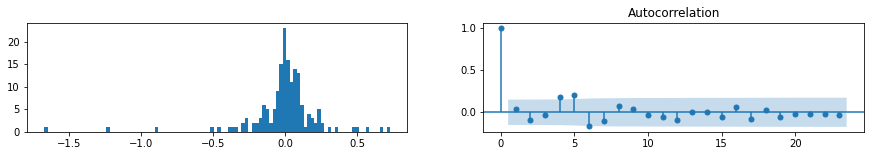

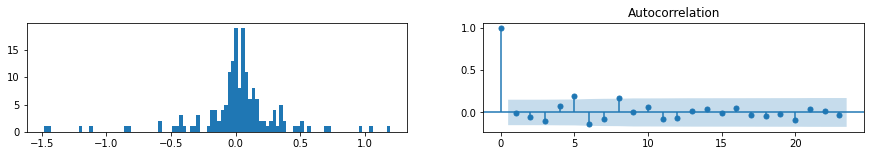

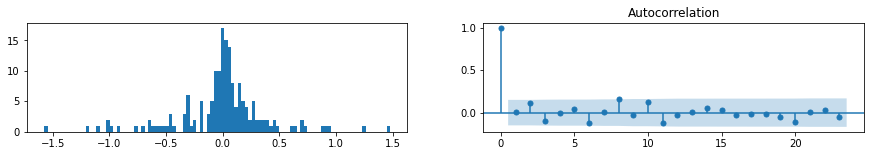

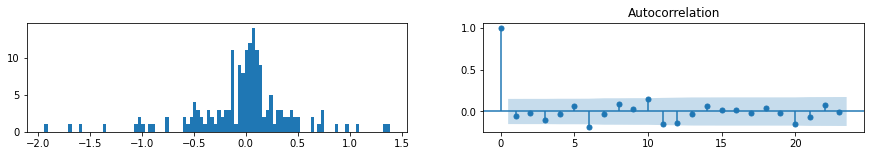

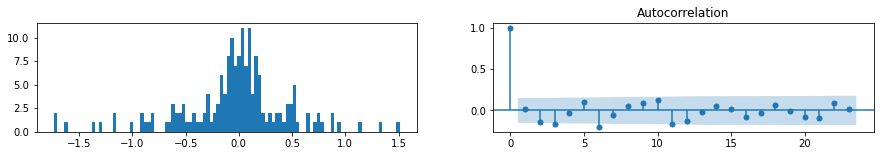

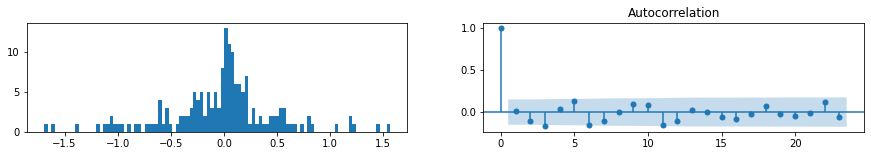

In [26]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )
            
            

            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices['Prediction'] - Prices['Real']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Visualization

[INFO] Feature:  PM2.5
------------------------------------------------


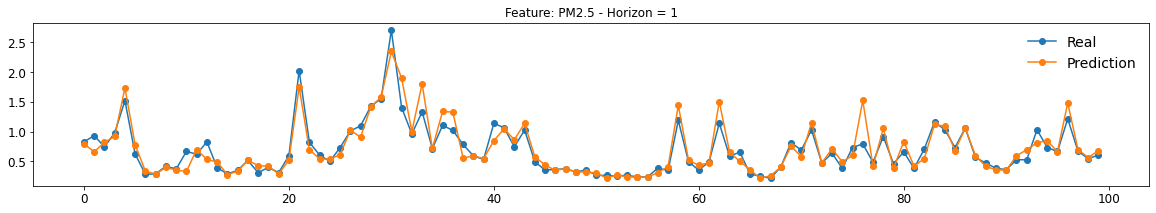

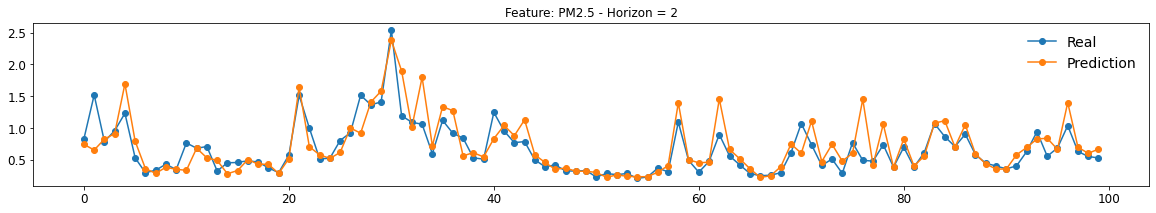

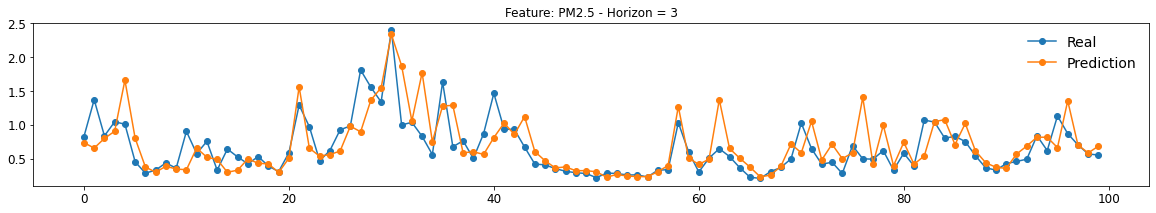

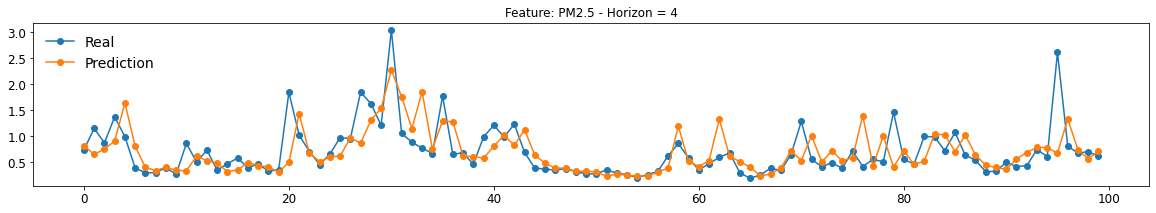

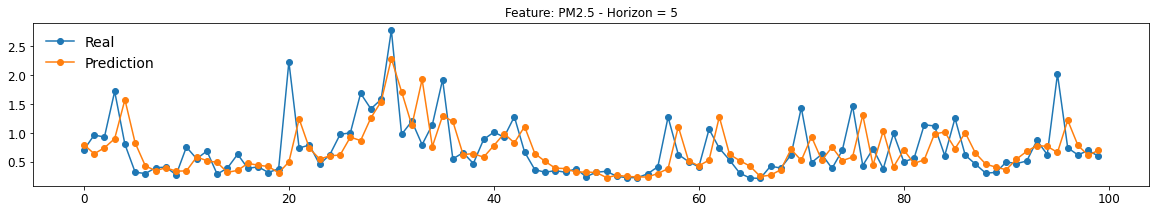

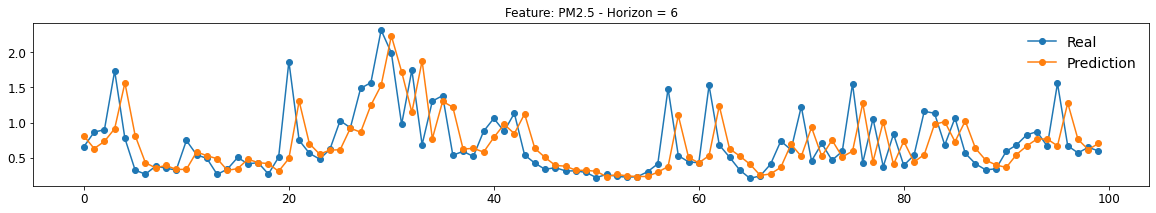

In [27]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )
            
            
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

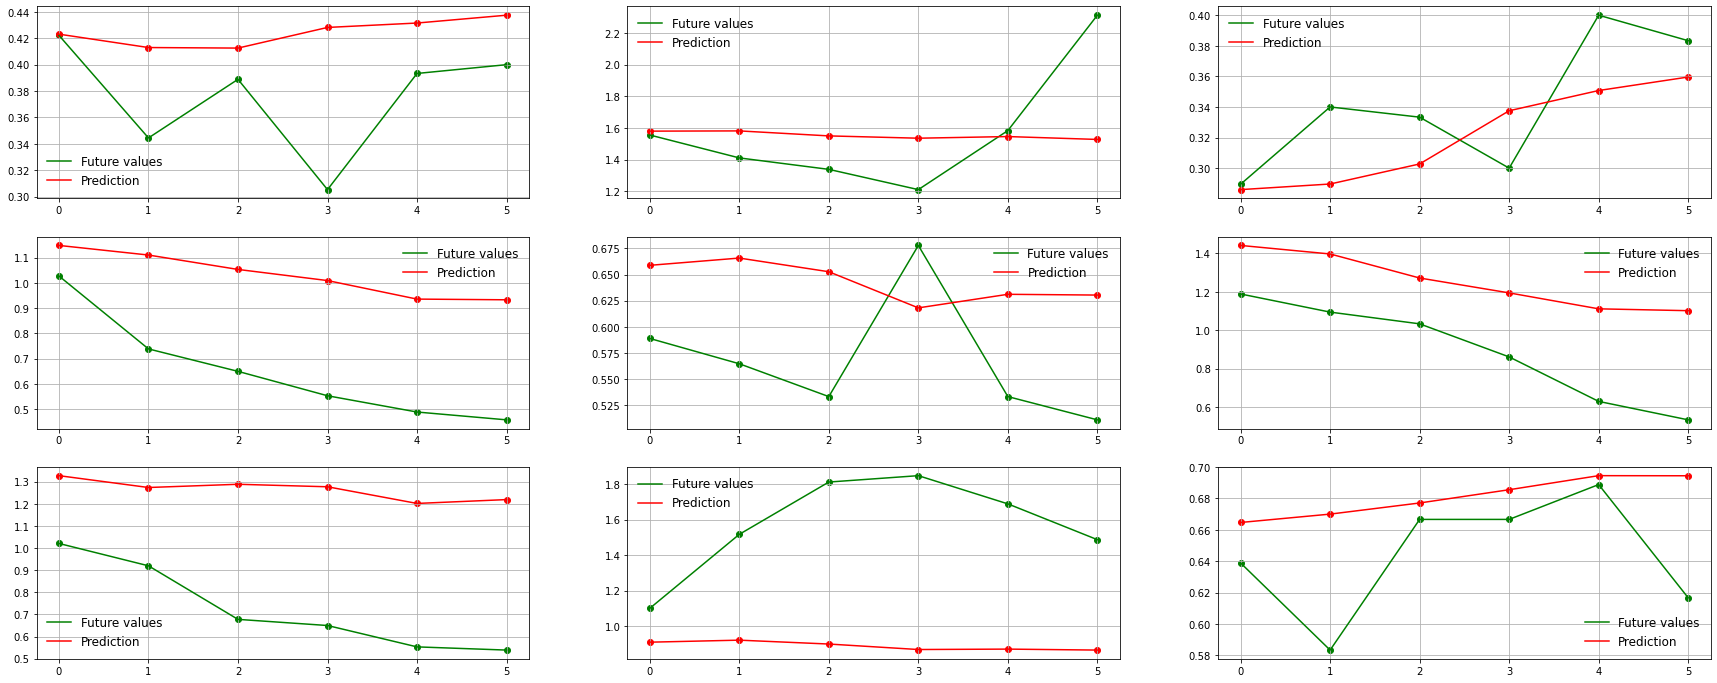

In [28]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (30, 12) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    Real       = scaler.inverse_transform( testY[i] )
    Prediction = scaler.inverse_transform( pred[i]   )

    # Apply inverse transformation   
    #
    if (Transformation == True):
        Real       = np.exp( Real )
        Prediction = np.exp( Prediction )
        
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range( Horizon ), Real, color='g')
    plot_scatter(range( Horizon ), Prediction, color='r')

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [29]:
df_test = df[ idx: ]
df_test['NBeats_NCA'] = pred.flatten()

df_test.to_csv('Predictions/NBeats_NCA.csv')